<hr>
__author__: Pedro Atencio
<br>
__email__: pedroatencio@itm.edu.co
<br>
__date__: July 2018
<hr>
# Video Summarization by Deep Visual and Categorical Diversity
<br>

<center><img src="model.png" width="500"></center>

In [26]:
import math

import numpy as np 
import matplotlib.pyplot as plt

import scipy.io as sio
from scipy.spatial.distance import cosine
from scipy.ndimage.filters import gaussian_filter1d

from utils.description import read_video, load_dcn_model, get_visual_representation
from utils.description import load_embedding_matrix, get_categorical_representation
from utils.description import activations_difference, normalize_data, norm_data
from utils.description import get_categorical_diversity, get_visual_diversity, get_combined_diversity

from scipy import signal

from utils import eval

<hr>
## 1. Load Pretrained Models

In [13]:
model_name = "resnet50"
(model, int_model) = load_dcn_model(model_name)

wb_path = 'pretrained-glove/glove.6B.100d.txt'
embedding_matrix = load_embedding_matrix(wb_path)

Loading model resnet50
Model loaded.
Found 400000 word vectors.


<hr>
## 2. Video Description

In [14]:
#1. video loading and processing
filename = "St Maarten Landing"
video_path = "video_dataset/SumMe/videos/"+filename+".webm"
(irate, video_frames) = read_video(video_path)

video_len = len(video_frames)

#2. compute visual representations
(model_activations, int_model_activations) = get_visual_representation(model, int_model, video_frames)

#3. compute categorical representations
categorical_activations = get_categorical_representation(embedding_matrix, model_activations)

Detected frame rate:  25
Sampling video to 1 frame per second.
70 frames extracted.


<hr>
## 3. Compute Visual and Categorical Diversity

In [15]:
'''
Visual and Categorical Diversity
'''

visual_diversity = get_visual_diversity(int_model_activations)
categorical_diversity = get_categorical_diversity(np.squeeze(categorical_activations))

'''
Multimodal diversity (combined and smoothed)
'''
combined_diversity = get_combined_diversity(visual_diversity, categorical_diversity)
video_diversity = gaussian_filter1d(combined_diversity, sigma=1.5, order=0)

Gaussian Visual and categorical diversity for video St Maarten Landing using DCN model: resnet50.


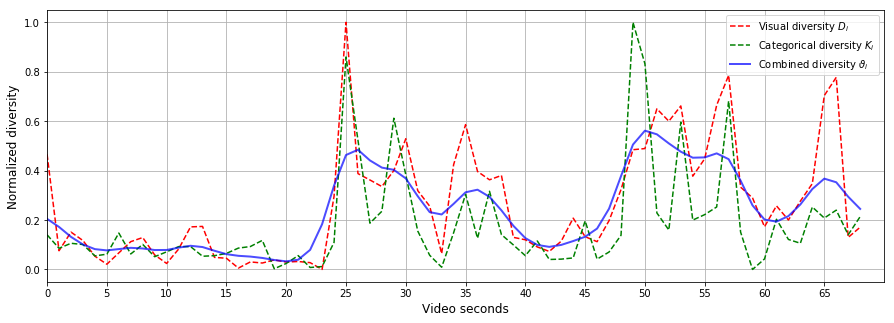

In [16]:
l = len(video_frames)
plt.figure(figsize=(15,5))
plt.xlim(0, l)
plt.xticks(np.arange(0, l, 5))
plt.grid()
plt.xlabel("Video seconds", fontsize=12)
plt.ylabel("Normalized diversity", fontsize=12)

lines = []
labels = []

line, = plt.plot(visual_diversity, label="Visual diversity "+ r'$D_i$', linewidth=1.5, color='r', linestyle='dashed')
lines.append(line)
labels.append("Visual diversity "+ r'$D_i$')

line, = plt.plot(categorical_diversity, label="Categorical diversity "+ r'$K_i$', linewidth=1.5, color='g', linestyle='dashed')
lines.append(line)
labels.append("Categorical diversity "+ r'$K_i$')

line, = plt.plot(video_diversity, label="Combined diversity "+ r'$\vartheta_i$', linewidth=2.0, color='b', alpha=0.7)
lines.append(line)
labels.append("Combined diversity "+ r'$\vartheta_i$')
    
plt.legend(lines, labels)

print("Gaussian Visual and categorical diversity for video "+ filename+ " using DCN model: "+model_name+".")
plt.show()

<hr>
## 4. Compute Video Summary

In [17]:
def get_summaries(video_diversity):
    expected_sum_len = 0.15 #alpha on paper.
    epsilon = 0.001
    tao_range = np.linspace(0, 1, 100000)

    total_frames = (len(video_diversity)+1)*irate+1
    
    upsampled_activation = signal.resample(video_diversity, total_frames)

    for tao in tao_range:
        summary_score =  upsampled_activation > tao
        sum_len = float(np.count_nonzero(summary_score)) / total_frames
        if( abs(expected_sum_len - sum_len) <= epsilon ):
            break

    print "tao: ", tao

    summary_continuous = upsampled_activation * summary_score
    summary_discrete = summary_score
    
    return (summary_discrete, summary_continuous)

In [18]:
(summary_discrete, summary_continuous) = get_summaries(video_diversity)

tao:  0.44878448784487845


Figure. Visual summary generation for video St Maarten Landing using DCN model: resnet50.


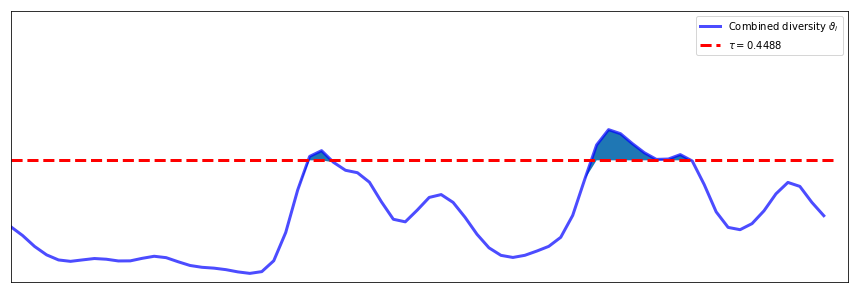

In [42]:
l = len(video_frames)
plt.figure(figsize=(15, 5))
plt.xlim(0, l)
plt.ylim(0, 1)

plt.xticks([])
plt.yticks([])

lines = []
labels = []

line, = plt.plot(video_diversity, label="Combined diversity "+ r'$\vartheta_i$', linewidth=3.0, color='b', alpha=0.7)
lines.append(line)
labels.append("Combined diversity "+ r'$\vartheta_i$')

tao = 0.44878448784487845

x_val = np.linspace(0, l-2, l-1)
y_truncated = np.array([tao if(video_diversity[i] > tao) else video_diversity[i] for i in range(l-1)])

plt.fill_between(x_val, video_diversity, y_truncated)

line, = plt.plot([tao for i in range(l)], color='red', linestyle="dashed", linewidth=3)
lines.append(line)
labels.append(r'$\tau= '+str(np.round(tao,4))+'$')

plt.legend(lines, labels)

print("Figure. Visual summary generation for video "+ filename+ " using DCN model: "+model_name+".")
plt.show()

<hr>
## 5. SumMe Evaluation

In [20]:
fscore = eval.SumMe_evaluation(filename, list(summary_continuous), plot_graph=False) 

F-measure : 0.610 at length 0.15


utils/summe.py:38: UserWarning: Crop selection (33269 frames) to GT length
  warnings.warn('Crop selection (%d frames) to GT length' %(len(summary_selection)-nFrames))


<hr>
## 6. Query Injection

In [23]:
'''
Transform query vector to GloVe
'''

#Video: playing_ball
#query_words = ('german', 'shepherd' , 'ping', 'pong', 'ball')

#Video: St. Maarten Landing
query_words = ('airship', 'aircraft')

embedding_dim = 100
query_glove = np.zeros([embedding_dim], dtype=np.float32)

for word in query_words:
    query_glove += embedding_matrix[word]

query_glove /= len(query_words)

#print query_glove

In [28]:
'''
Compute cosine distance between query vector and categorical 
representation of video
'''

query_cosine = np.zeros([video_len], dtype=np.float32)

for i in range(video_len):
    query_cosine[i] = 1 - cosine(categorical_activations[i], query_glove)

In [36]:
'''
Compute combined diversity with query cosine similarity
'''

combined_query_diversity = get_combined_diversity(combined_diversity, query_cosine[0:video_len-1])
video_query_diversity = gaussian_filter1d(combined_query_diversity, sigma=1.5, order=0) 

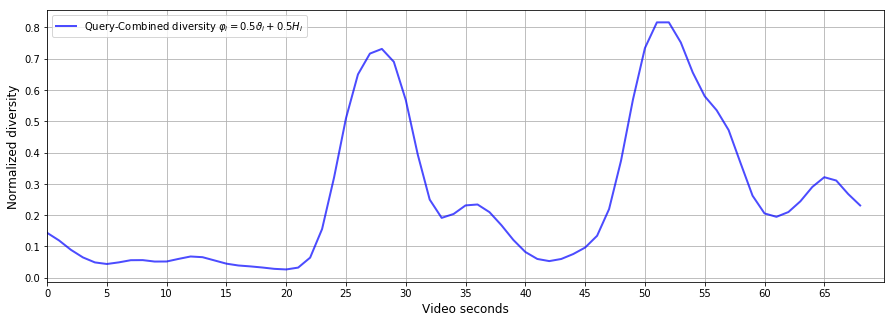

In [41]:
l = video_len
plt.figure(figsize=(15,5))
plt.xlim(0, l)
plt.xticks(np.arange(0, l, 5))
plt.grid()
plt.xlabel("Video seconds", fontsize=12)
plt.ylabel("Normalized diversity", fontsize=12)

lines = []
labels = []

line, = plt.plot(video_query_diversity, label="video_query_diversity "+ r'$\vartheta_i$', linewidth=2.0, color='b', alpha=0.7)
lines.append(line)
labels.append("Query-Combined diversity "+ r'$\varphi_i = 0.5\vartheta_i + 0.5H_i$')

plt.legend(lines, labels)

plt.show()

In [44]:
(query_summary_discrete, query_summary_continuous) = get_summaries(video_query_diversity)

tao:  0.5814758147581476


Figure. Visual summary generation for video St Maarten Landing using DCN model: resnet50.


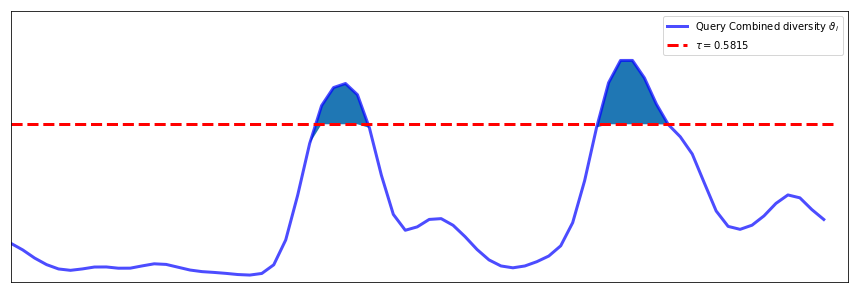

In [47]:
l = len(video_frames)
plt.figure(figsize=(15, 5))
plt.xlim(0, l)
plt.ylim(0, 1)

plt.xticks([])
plt.yticks([])

lines = []
labels = []

line, = plt.plot(video_query_diversity, label="Query Combined diversity "+ r'$\vartheta_i$', linewidth=3.0, color='b', alpha=0.7)
lines.append(line)
labels.append("Query Combined diversity "+ r'$\vartheta_i$')

tao = 0.5814758147581476

x_val = np.linspace(0, l-2, l-1)
y_truncated = np.array([tao if(video_query_diversity[i] > tao) else video_query_diversity[i] for i in range(l-1)])

plt.fill_between(x_val, video_query_diversity, y_truncated)

line, = plt.plot([tao for i in range(l)], color='red', linestyle="dashed", linewidth=3)
lines.append(line)
labels.append(r'$\tau= '+str(np.round(tao,4))+'$')

plt.legend(lines, labels)

print("Figure. Visual summary generation for video "+ filename+ " using DCN model: "+model_name+".")
plt.show()

<hr>
## 7. Video Results

In [ ]:
from scipy.signal import resample

In [53]:
#summaries are returned in number of frames. We need them in number of seconds.

summary_seconds = resample(summary_discrete, video_len)
query_summary_seconds = resample(query_summary_discrete, video_len)

In [56]:
'''
Video segments for normal summary
'''

summary_seconds = summary_seconds > 0.0

summary_location = np.where(summary_seconds == True)[0]
summary_derivative = np.diff(summary_location)

segments_dict = {'S0':summary_location[0]}
c = 0

for i in range(len(summary_derivative)):
    if(summary_derivative[i] > 1):
        c += 1
        segments_dict['S'+str(c)] = summary_location[i]
        c += 1
        segments_dict['S'+str(c)] = summary_location[i+1]

segments_dict['S'+str(c+1)] = summary_location[i+1]

In [58]:
'''
Video segments for query-based summary
'''

summary_seconds = query_summary_seconds > 0.0

summary_location = np.where(summary_seconds == True)[0]
summary_derivative = np.diff(summary_location)

query_segments_dict = {'S0':summary_location[0]}
c = 0

for i in range(len(summary_derivative)):
    if(summary_derivative[i] > 1):
        c += 1
        query_segments_dict['S'+str(c)] = summary_location[i]
        c += 1
        query_segments_dict['S'+str(c)] = summary_location[i+1]

query_segments_dict['S'+str(c+1)] = summary_location[i+1]

In [67]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
      
def create_video_from_summary(video_path, result_name, segments_dict):
    '''
    Create a mp4 video mantaining video seconds in segments_dict
    from original video in video_path.
    '''
    summary = []
    complete_video = VideoFileClip(video_path)

    for i in range(0, len(segments_dict)-1, 2):

        (a,b) = (segments_dict['S'+str(i)], segments_dict['S'+str(i+1)])
        clip = complete_video.subclip(a, b)

        summary.append(clip)

    final_clip = concatenate_videoclips(summary)
    final_clip.write_videofile(result_name+".mp4")

In [61]:
create_video_from_summary(video_path, "summary", segments_dict)
create_video_from_summary(video_path, "query_summary", query_segments_dict)

[MoviePy] >>>> Building video summary.mp4
[MoviePy] Writing video summary.mp4


100%|█████████▉| 275/276 [00:02<00:00, 117.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: summary.mp4 

[MoviePy] >>>> Building video query_summary.mp4
[MoviePy] Writing video query_summary.mp4


100%|█████████▉| 250/251 [00:01<00:00, 123.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: query_summary.mp4 



In [62]:
from IPython.display import HTML

HTML("""
<h2>Original video: """+filename+"""</h2>
<video width="640" height="480" controls>
    <source src="video_dataset/SumMe/videos/"""+filename+""".webm" type="video/webm">
</video> 
""")

In [65]:
HTML("""
<h2>Summary generated by model: """+model_name+"""</h2>
<video width="640" height="480" controls>
    <source src="summary.mp4" type="video/mp4">
</video> 
""") 

In [66]:
HTML("""
<h2>Summary generated by model: """+model_name+"""</h2>
<video width="640" height="480" controls>
    <source src="query_summary.mp4" type="video/mp4">
</video> 
""") 